In [370]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statistics as st
from datetime import datetime
import cartopy.crs as crs
import geopandas as gpd
import matplotlib.patches as mpatches
import cartopy.feature as cfeature
import matplotlib.image as mpimg

In [371]:
# df = pd.read_parquet('/home/aevans/nwp_bias/src/machine_learning/data/nysm_hrrr/VOOR/VOOR_fh1_t2m_HRRR_ml_output_linear.parquet')
# df

In [372]:
# ldf = pd.DataFrame()
# for i in np.arange(9, 10):
#     model_path_LSTM = f"/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/hrrr_prospectus/LOUI/LOUI_fh{i}_tp_HRRR_ml_output_linear.parquet"

#     # Read parquet file
#     ldf_ = pd.read_parquet(model_path_LSTM)

#     # Concatenate with the main DataFrame
#     ldf = pd.concat([ldf_, ldf], ignore_index=True)
#     print(ldf.shape)

# # Sort by valid_time
# ldf = ldf.sort_values(by="valid_time").reset_index(drop=True)

In [373]:
ldf = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/oksm_hrrr/KETC/KETC_fh14_u_total_HRRR_ml_output_linear.parquet"
)
# for c in ldf.columns:
#     if c != "valid_time":
#         ldf[c] = ldf[c] / 3000
# ldf

(-15.0, 15.0)

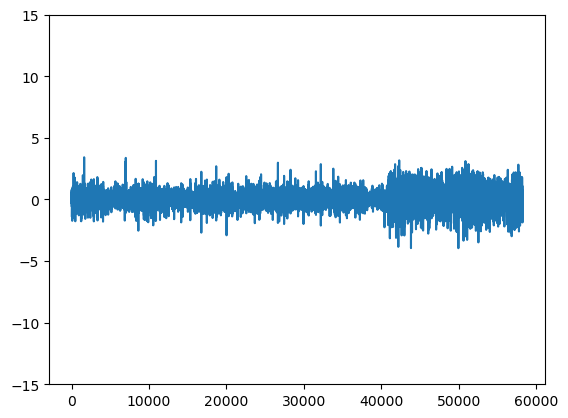

In [374]:
plt.plot(ldf["diff"])
plt.ylim(-15, 15)

In [375]:
import sys

sys.path.append("..")

from src.data import nysm_data
from src.data import gfs_data
from src.data import nam_data

In [376]:
nysm_df = nysm_data.load_nysm_data(gfs=False)
# nysm_df = nysm_df.rename(columns={'time_1H':'valid_time'})
# gfs_df = gfs_data.read_gfs_data('012')
station = "Voorheesville"

In [377]:
# nysm_df

In [378]:
ldf.dropna(inplace=True)
ldf.head()

,target_error,Model forecast,diff,valid_time
0,0.010769,0.646954,-0.275163,2018-01-01 14:00:00
1,1.191579,0.877234,0.787269,2018-01-01 15:00:00
2,0.865650,1.827314,-0.027062,2018-01-01 16:00:00
3,0.694558,2.079273,-0.327677,2018-01-01 17:00:00
4,0.768923,1.460199,0.064932,2018-01-01 18:00:00


In [379]:
def which_fold(df, fold):
    length = len(df)
    test_len = int(length * 0.2)
    df_train = pd.DataFrame()

    for n in np.arange(0, 5):
        if n != fold:
            df1 = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]
            df_train = pd.concat([df_train, df1])
        else:
            df_test = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]
            f = int(len(df_test) * 0.5)
            df_val = df_test.iloc[:f]
            df_test = df_test[-f:]

    return df_train["valid_time"], df_test["valid_time"], df_val["valid_time"]

In [380]:
# ldf["valid_time"] = pd.to_datetime(ldf["valid_time"])

In [381]:
df_train, df_test, df_val = which_fold(ldf, 4)

In [382]:
test_set_start = df_test.iloc[0]
test_set_start

Timestamp('2024-04-28 15:00:00')

In [383]:
test_set_finish = df_test.iloc[-1]
test_set_finish

Timestamp('2024-12-28 10:00:00')

In [384]:
df_val.iloc[0]

Timestamp('2023-08-28 11:00:00')

In [385]:
df_val.iloc[-1]

Timestamp('2024-04-28 14:00:00')

In [386]:
def date_filter(ldf, time1, time2):
    ldf = ldf[ldf["valid_time"] > time1]
    ldf = ldf[ldf["valid_time"] < time2]

    return ldf

In [387]:
def met_output(df, station, fh):
    fig, ax = plt.subplots(figsize=(24, 6))
    x = df["valid_time"]

    # Convert datetime values to numerical values
    x_numeric = mdates.date2num(x)

    # Assuming your timestamps are in a datetime64 format
    day_mask = (x.dt.hour >= 6) & (
        x.dt.hour < 18
    )  # Adjust the hours based on your day/night definition

    plt.plot(
        np.array(x),
        np.array(df[f"u_total_{station}"]),
        c="mediumseagreen",
        linewidth=3,
        label="NAM Prediction",
    )

    plt.plot(
        np.array(x),
        np.array(df["reforecast"]),
        c="red",
        linewidth=3,
        linestyle="--",  # Dashed line
        label="LSTM Reforecast",
    )

    plt.plot(
        np.array(x),
        np.array(df[f"wspd_sonic_mean_{station}"]),
        c="black",
        linewidth=1,
        alpha=0.9,
        label="NYSM Observation",
    )

    # Fill daytime hours with white color
    ax.fill_between(
        x_numeric, 0, 10, where=day_mask, color="white", alpha=0.5, label="Daytime"
    )

    # Fill nighttime hours with grey color
    ax.fill_between(
        x_numeric, 0, 10, where=~day_mask, color="grey", alpha=0.2, label="Nighttime"
    )

    ax.set_title(f"GFS Prediction v NYSM Observation: {station}: FH{fh}", fontsize=28)
    # plt.ylim(-5, 5.)
    ax.legend()
    plt.show()

# TIME FILTER

In [388]:
time1 = datetime(2024, 7, 1, 0, 0, 0)
time2 = datetime(2024, 7, 30, 23, 0, 0)

ldf = date_filter(ldf, time1, time2)
nysm_df = date_filter(nysm_df, time1, time2)
# gfs_df = date_filter(gfs_df, time1, time2)

In [389]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np


def ml_output(
    df,
    fold,
    station,
    test_set_start,
    test_set_finish,
    fill_between_min,
    fill_between_max,
):
    fig, ax = plt.subplots(figsize=(24, 6))
    x = df["valid_time"]

    # Convert datetime values to numerical values
    x_numeric = mdates.date2num(x)

    # Assuming your timestamps are in a datetime64 format
    day_mask = (x.dt.hour >= 6) & (
        x.dt.hour < 18
    )  # Adjust the hours based on your day/night definition

    plt.plot(
        np.array(x),
        np.array(df["target_error"]),
        c="black",
        linewidth=1,
        label="Target",
    )

    plt.plot(
        np.array(x),
        np.array(df["Model forecast"]),
        c="red",
        linewidth=3,
        alpha=0.7,
        label="LSTM Output",
    )
    # plt.plot(
    #     np.array(x),
    #     np.array(df2["Model forecast"]),
    #     c="blue",
    #     linewidth=3,
    #     alpha=0.7,
    #     label="LSTM Output: alpha2",
    # )
    # plt.plot(
    #     np.array(x),
    #     np.array(df3["Model forecast"]),
    #     c="darkviolet",
    #     linewidth=3,
    #     alpha=0.7,
    #     label="LSTM Output:alpha3",
    # )

    # Fill daytime hours with white color
    ax.fill_between(
        x_numeric,
        fill_between_min,
        fill_between_max,
        where=day_mask,
        color="white",
        alpha=0.5,
        label="Daytime",
    )

    # Fill nighttime hours with grey color
    ax.fill_between(
        x_numeric,
        fill_between_min,
        fill_between_max,
        where=~day_mask,
        color="grey",
        alpha=0.2,
        label="Nighttime",
    )

    ax.set_title(f"HRRR Wind Error LSTM Output v Target: {station}", fontsize=28)
    # plt.ylim(-5, 5.)
    ax.legend()

    plt.show()

In [390]:
ldf.head()

,target_error,Model forecast,diff,valid_time
53942,-1.351968,-1.041961,-0.769688,2024-07-01 01:00:00
53943,-1.731967,-1.341862,-0.995519,2024-07-01 02:00:00
53944,-0.370708,-1.551775,0.473649,2024-07-01 03:00:00
53945,0.492820,0.603237,0.229363,2024-07-01 04:00:00
53946,0.900463,3.671535,-0.940296,2024-07-01 05:00:00


In [391]:
# ldf["diff"] = ldf.iloc[:, 0] - ldf.iloc[:, 1]
# ldf["target_error_lead_0"] = ldf["target_error"] *2.5
# ldf["Model forecast"] = ldf["Model forecast"] *2

In [392]:
mean = st.mean(abs(ldf["diff"]))
mean

0.5672525490909058

In [393]:
mean_s = st.mean(ldf["diff"] ** 2)
mean_s

0.49894849493887267

In [394]:
# df = pd.read_parquet('/home/aevans/nwp_bias/src/machine_learning/data/oksm/hrrr_data/fh01/HRRR_2018_01_direct_compare_to_oksm_sites_mask_water.parquet').reset_index()
# df = df[df['station']=='BRIS']
# plt.plot(df['u_total'])

In [395]:
# df2 = pd.read_parquet('/home/aevans/nwp_bias/data/oksm/oksm_1H_obs_2024.parquet').reset_index()
# df2 = df2[df2['station']=='BRIS']
# df2

# MODEL OUTPUT

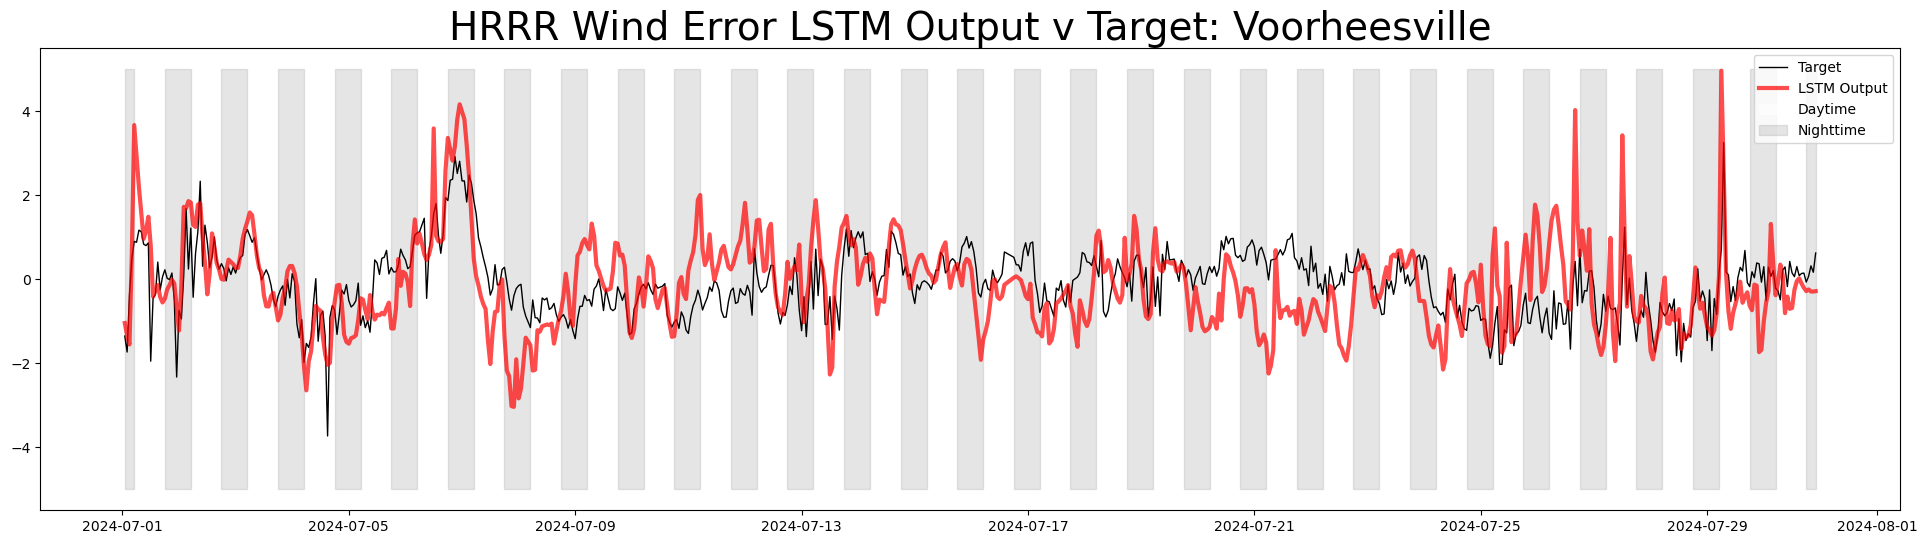

In [396]:
x = ml_output(ldf, 4, station, test_set_start, test_set_finish, -5, 5)

In [397]:
def plot_fh_drift(mae_ls, clim_divs, nwp_model, metvar):
    """
    Plots Mean Absolute Error (MAE) as a function of forecast hour (fh) for multiple climate divisions.

    Parameters:
        mae_dict (dict): Dictionary where keys are climate divisions and values are lists of MAE values.
        fh (list): Forecast hours.
        station (str): Station identifier.
        nwp_model (str): Numerical weather prediction model name.
        metvar (str): Meteorological variable.
    """
    plt.figure(figsize=(12, 7))
    fh = np.arange(1, 19)

    colors = [
        "blue",
        "green",
        "red",
        "orange",
        "darkviolet",
        "brown",
        "black",
        "gray",
        "darkcyan",
        "deeppink",
    ]  # Color palette
    for i, _ in enumerate(mae_ls):
        color = colors[i % len(colors)]  # Cycle through colors
        plt.plot(
            fh, mae_ls[i], label=clim_divs[i], marker="o", linestyle="-", color=color
        )
        plt.scatter(fh, mae_ls[i], marker="o", s=100, color=color)

        # # Annotate points
        # for j, txt in enumerate(mae_ls[i]):
        #     plt.annotate(
        #         f"{txt:.2f}",
        #         (fh[j], mae_ls[i][j]),
        #         textcoords="offset points",
        #         xytext=(0, 10),
        #         ha="center",
        #         fontsize=10,
        #         color=color,
        #     )

    # Add labels, legend, and title
    plt.xlabel("Forecast Hour (FH)", fontsize=16)
    plt.ylabel("Mean Absolute Error (MAE)", fontsize=16)
    plt.title(
        f"MAE as a Function of Forecast Hour\n{nwp_model}, {metvar}-Error",
        fontsize=18,
    )
    plt.legend(title="Climate Division", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)

    # Ensure x-ticks are integers
    plt.xticks(ticks=range(int(min(fh)), int(max(fh)) + 1), fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0, 1)

    plt.tight_layout()

In [398]:
import seaborn as sns


def plot_mae_boxplot(wind_df_list, temp_df_list, precip_df_list, climate_divisions):
    """
    Creates a grouped boxplot where each climate division has three boxplots
    representing wind error, temperature error, and precipitation error.

    Parameters:
        wind_df_list (list of pd.DataFrame): List of DataFrames containing 'mae' for wind error.
        temp_df_list (list of pd.DataFrame): List of DataFrames containing 'mae' for temperature error.
        precip_df_list (list of pd.DataFrame): List of DataFrames containing 'mae' for precipitation error.
        climate_divisions (list of str): Names of the corresponding climate divisions.
    """
    # Create a list to store the MAE values with their associated climate division and variable type
    plot_data = []

    for clim_div, wind_df, temp_df, precip_df in zip(
        climate_divisions, wind_df_list, temp_df_list, precip_df_list
    ):
        if "mae" in wind_df.columns:
            for mae_val in wind_df["mae"]:
                plot_data.append(
                    {"Climate Division": clim_div, "MAE": mae_val, "Variable": "Wind"}
                )

        if "mae" in temp_df.columns:
            for mae_val in temp_df["mae"]:
                plot_data.append(
                    {
                        "Climate Division": clim_div,
                        "MAE": mae_val,
                        "Variable": "Temperature",
                    }
                )

        if "mae" in precip_df.columns:
            for mae_val in precip_df["mae"]:
                plot_data.append(
                    {
                        "Climate Division": clim_div,
                        "MAE": mae_val,
                        "Variable": "Precipitation",
                    }
                )

    # Convert to DataFrame
    plot_df = pd.DataFrame(plot_data)

    # Create the boxplot
    plt.figure(figsize=(14, 8))
    sns.boxplot(
        x="Climate Division", y="MAE", hue="Variable", data=plot_df, palette="Set2"
    )

    # Format the plot
    plt.xlabel("Climate Division", fontsize=14)
    plt.ylabel("Mean Absolute Error (MAE)", fontsize=14)
    plt.title(
        "MAE Distribution Across Climate Divisions for Forecast Error", fontsize=16
    )
    plt.xticks(rotation=45)  # Rotate labels for readability
    plt.legend(title="Variable", fontsize=12, loc="upper right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.ylim(0, 1)

    # Show the plot
    plt.tight_layout()
    plt.savefig(
        "/home/aevans/nwp_bias/src/machine_learning/notebooks/clim_div_boxplots.png"
    )
    plt.show()

In [399]:
geo_info_df = pd.read_csv(
    "/home/aevans/nwp_bias/src/landtype/data/lstm_clusters_ok.csv"
)

lulc_dict = geo_info_df.set_index("station")["lulc_cat"].to_dict()
elev_dict = geo_info_df.set_index("station")["elev_cat"].to_dict()
slope_dict = geo_info_df.set_index("station")["slope_cat"].to_dict()

In [400]:
geo_info_df.head()

,Unnamed: 0,index,station,lulc_cat,elev_cat,slope_cat
0,0,0,ACME,1,4,0
1,1,1,ADAX,4,2,0
2,2,2,ALTU,0,4,0
3,3,3,ALV2,0,2,0
4,4,4,ALVA,0,2,0


In [401]:
def geo_map(df, lulc_dict, elev_dict, slope_dict):
    df["lulc"] = df["station"].map(lulc_dict)
    df["elev"] = df["station"].map(elev_dict)
    df["slope"] = df["station"].map(slope_dict)
    return df

In [402]:
clims = pd.read_csv("/home/aevans/nwp_bias/src/landtype/data/oksm.csv")
clim_divs = clims["Climate_division"].unique().tolist()

In [403]:
error_path = "/home/aevans/nwp_bias/src/machine_learning/data/error_visuals"

error_dir = os.listdir(error_path)
error_dir = sorted(error_dir)

error_dir = [e for e in error_dir if e in clim_divs]

temp_master_ls = []
wind_master_ls = []
tp_master_ls = []

temp_df_ls = []
wind_df_ls = []
precip_df_ls = []

for d in error_dir:
    print(d)
    error_df1 = pd.read_parquet(
        f"{error_path}/{d}/{d}_tp_error_metrics_master_normalized.parquet"
    )
    error_df2 = pd.read_parquet(
        f"{error_path}/{d}/{d}_u_total_error_metrics_master_normalized.parquet"
    )
    error_df3 = pd.read_parquet(
        f"{error_path}/{d}/{d}_t2m_error_metrics_master_normalized.parquet"
    )
    # Group by forecast hour (fh) and compute the mean MAE
    mean_mae_by_fh1 = error_df1.groupby("fh")["mae"].mean().reset_index()
    mean_mae_by_fh2 = error_df2.groupby("fh")["mae"].mean().reset_index()
    mean_mae_by_fh3 = error_df3.groupby("fh")["mae"].mean().reset_index()

    temp_df_ls.append(error_df3.reset_index())
    wind_df_ls.append(error_df2.reset_index())
    precip_df_ls.append(error_df1.reset_index())

    mae1 = mean_mae_by_fh1["mae"].values
    mae2 = mean_mae_by_fh2["mae"].values
    mae3 = mean_mae_by_fh3["mae"].values

    temp_master_ls.append(mae3)
    wind_master_ls.append(mae2)
    tp_master_ls.append(mae1)

Central
East Central
North Central
Northeast
Panhandle
South Central
Southeast
Southwest
West Central


In [404]:
mae_df = pd.concat(precip_df_ls)
st.mean(mae_df["mae"])

0.1706410054575191

In [405]:
grouped = mae_df.groupby("station")["mae"].mean()
grouped

station
ACME    0.152758
ADAX    0.174956
ALTU    0.130232
ALV2    0.138529
ANT2    0.205755
          ...   
WEST    0.191116
WILB    0.199909
WIST    0.197659
WOOD    0.131811
WYNO    0.177467
Name: mae, Length: 115, dtype: float64

In [406]:
nysm_df = pd.read_csv("/home/aevans/nwp_bias/src/landtype/data/oksm.csv")
keys = nysm_df["stid"].values
lats = nysm_df["nlat"].values
lons = nysm_df["elon"].values

station_coords = {k: (lat, lon) for k, lat, lon in zip(keys, lats, lons)}

In [407]:
grouped_df = pd.DataFrame({"station": grouped.index, "mae": grouped.values})

# Add lat/lon from your station_coords dictionary
grouped_df["lat_lon"] = grouped_df["station"].map(station_coords)

In [408]:
grouped_df[["lat", "lon"]] = pd.DataFrame(
    grouped_df["lat_lon"].tolist(), index=grouped_df.index
)

In [409]:
grouped_df

,station,mae,lat_lon,lat,lon
0,ACME,0.152758,"(34.80833, -98.02325)",34.80833,-98.02325
1,ADAX,0.174956,"(34.79851, -96.66909)",34.79851,-96.66909
2,ALTU,0.130232,"(34.58722, -99.33808)",34.58722,-99.33808
3,ALV2,0.138529,"(36.70823, -98.70974)",36.70823,-98.70974
4,ANT2,0.205755,"(34.24967, -95.66844)",34.24967,-95.66844
...,...,...,...,...,...
110,WEST,0.191116,"(36.011, -94.64496)",36.01100,-94.64496
111,WILB,0.199909,"(34.90092, -95.34805)",34.90092,-95.34805
112,WIST,0.197659,"(34.98426, -94.68778)",34.98426,-94.68778
113,WOOD,0.131811,"(36.42329, -99.41682)",36.42329,-99.41682


In [410]:
clim_div = [
    "St. Lawrence Valley",
    "Great Lakes",
    "Northern Plateau",
    "Champlain Valley",
    "Hudson Valley",
    "Mohawk Valley",
    "Western Plateau",
    "Eastern Pleateau",
    "Coastal",
    "Central Lakes",
]
# clim_div = sorted(clim_div)
image = "/home/aevans/nwp_bias/src/landtype/data/NCEI_logo.png"
nysm_clim = pd.read_csv("/home/aevans/nwp_bias/src/landtype/data/nysm.csv")

In [411]:
# def create_xCITE_gif(grouped_df, clim_div=clim_div, nysm_clim=nysm_clim, logo=image):
#     # Create your dataframe df_
#     df_ = nysm_clim.copy()

#     # Create plot
#     fig = plt.figure(figsize=(24, 16))
#     ax = fig.add_subplot(
#         1,
#         1,
#         1,
#         projection=crs.LambertConformal(
#             central_longitude=-75.0, standard_parallels=(49, 77)
#         ),
#     )

#     # Load the shapefile for boundaries
#     shapefile_path = "/home/aevans/nwp_bias/src/machine_learning/notebooks/data/GIS.OFFICIAL_CLIM_DIVISIONS.shp"
#     gdf = gpd.read_file(shapefile_path)

#     ny_state_boundaries_path = "/home/aevans/nwp_bias/src/landtype/data/State.shx"
#     ny_state_boundaries_geo = gpd.read_file(ny_state_boundaries_path).to_crs(epsg=4326)

#     ny_bbox = ny_state_boundaries_geo.total_bounds
#     gdf_filtered = gdf.cx[ny_bbox[0] : ny_bbox[2], ny_bbox[1] : ny_bbox[3]]
#     gdf_filtered = pd.concat([gdf_filtered.iloc[20:29], gdf_filtered.iloc[[32]]])

#     # Create a categorical column for plotting
#     gdf_filtered["category"] = np.arange(len(gdf_filtered))

#     # Plot shapefile with climate divisions (remove the automatic legend)
#     gdf_filtered.plot(
#         ax=ax,
#         transform=crs.PlateCarree(),
#         column="category",
#         cmap="tab10",
#         alpha=0.3,
#         legend=False,
#     )

#     # Create legend for climate divisions using the colors from the 'tab10' colormap and labels from 'clim_div'
#     division_patches = [
#         mpatches.Patch(
#             color=plt.cm.tab10(i / len(gdf_filtered)), alpha=0.3, label=clim_div[i]
#         )
#         for i in range(len(gdf_filtered))
#     ]

#     # Add the climate divisions legend
#     legend1 = ax.legend(
#         handles=division_patches,
#         loc="upper right",
#         title="Climate Divisions",
#         fontsize=18,
#     )
#     ax.add_artist(legend1)  # Ensure the first legend is added to the plot

#     # Set extent for the plot
#     ax.set_extent([-80.0, -72.0, 40.0, 45.5], crs=crs.PlateCarree())

#     # Add features
#     ax.add_feature(cfeature.BORDERS.with_scale("50m"), linestyle=":", zorder=1)
#     ax.add_feature(cfeature.STATES.with_scale("50m"), linestyle=":", zorder=1)
#     ax.add_feature(cfeature.LAKES.with_scale("50m"), zorder=1)
#     ax.gridlines(
#         crs=crs.PlateCarree(),
#         draw_labels=True,
#         linewidth=2,
#         color="black",
#         alpha=0.5,
#         linestyle="--",
#     )

#     # Annotate scatter points with station IDs
#     for i, row in df_.iterrows():
#         ax.annotate(
#             row["stid"],
#             (row["lon [degrees]"], row["lat [degrees]"]),
#             textcoords="offset points",
#             xytext=(0, 10),
#             ha="center",
#             fontsize=12,
#             color="black",
#             transform=crs.PlateCarree(),
#         )

#     # Plot scatter points
#     sc = ax.scatter(
#         grouped_df["lon"],
#         grouped_df["lat"],
#         s=grouped_df["mae"] * 2000,
#         c=grouped_df["mae"],
#         cmap="viridis",
#         edgecolor="black",
#         transform=crs.PlateCarree(),
#         zorder=10,
#         vmin=0,
#         vmax=0.8,
#     )

#     # Add colorbar
#     cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.6, pad=0.05)
#     cbar.set_label("MAE", fontsize=20)

#     # Add plot title
#     plt.title(
#         f"NCEI New York State Climate Divisions",
#         fontsize=24,
#     )
#     # # Load and add the logo to the lower left
#     # logo_img = mpimg.imread(logo)
#     # ax.figure.figimage(
#     #     logo_img, 50, 50, zorder=20, alpha=0.5
#     # )  # Adjust (x, y) position as needed
#     # # Show plot
#     plt.show()

In [412]:
clim_div = [
    "Northeast",
    "West Central",
    "Central",
    "East Central",
    "Southwest",
    "South Central",
    "Southeast",
    "Panhandle",
    "North Central",
    "Nan",
    "Nan1",
    "Nan2",
    "Nan3",
]


def create_xCITE_gif(grouped_df, clim_div=clim_div, logo=image):

    # Create plot
    fig = plt.figure(figsize=(24, 16))
    ax = fig.add_subplot(
        1,
        1,
        1,
        projection=crs.LambertConformal(
            central_longitude=-98.0, standard_parallels=(30, 40)
        ),
    )

    # Load the shapefile for boundaries
    shapefile_path = "/home/aevans/nwp_bias/src/machine_learning/notebooks/data/GIS.OFFICIAL_CLIM_DIVISIONS.shp"
    gdf = gpd.read_file(shapefile_path)
    gdf_filtered = pd.concat([gdf.iloc[191:198], gdf.iloc[172:175]])
    gdf_filtered["category"] = np.arange(len(gdf_filtered))

    # Create legend for climate divisions using the colors from the 'tab10' colormap and labels from 'clim_div'
    division_patches = [
        mpatches.Patch(
            color=plt.cm.tab10(i / len(gdf_filtered)), alpha=0.3, label=clim_div[i]
        )
        for i in range(len(gdf_filtered) - 1)
    ]

    # Add the climate divisions legend
    legend1 = ax.legend(
        handles=division_patches,
        loc="lower left",
        title="Climate Divisions",
        fontsize=18,
    )
    ax.add_artist(legend1)  # Ensure the first legend is added to the plot

    # Set extent for the plot
    ax.set_extent([-103.0, -94.0, 33.0, 37.5], crs=crs.PlateCarree())

    # Add features
    ax.add_feature(cfeature.BORDERS.with_scale("50m"), linestyle=":", zorder=1)
    ax.add_feature(cfeature.STATES.with_scale("50m"), linestyle=":", zorder=1)
    ax.add_feature(cfeature.LAKES.with_scale("50m"), zorder=1)
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    gdf_filtered.plot(
        ax=ax,
        transform=crs.PlateCarree(),
        column="category",
        cmap="tab10",
        alpha=0.3,
        legend=False,
    )

    # Plot scatter points
    sc = ax.scatter(
        grouped_df["lon"],
        grouped_df["lat"],
        s=grouped_df["mae"] * 3000,
        c=grouped_df["mae"],
        cmap="viridis",
        edgecolor="black",
        transform=crs.PlateCarree(),
        zorder=10,
        vmin=0,
        vmax=0.8,
    )

    # Annotate scatter points with station IDs
    for i, row in grouped_df.iterrows():
        ax.annotate(
            row["station"],
            (row["lon"], row["lat"]),
            textcoords="offset points",
            xytext=(-10, 15),
            ha="center",
            fontsize=15,
            color="black",
            transform=crs.PlateCarree(),
        )

    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.6, pad=0.05)
    # Make colorbar tick labels bigger
    cbar.ax.tick_params(labelsize=18)  # <-- change 14 to whatever size you want
    cbar.set_label("MAE", fontsize=20)

    # Add plot title
    plt.title(
        f"LSTM MAE Averaged Across Forecast-Hours, HRRR",
        fontsize=24,
    )
    # # Load and add the logo to the lower left
    # logo_img = mpimg.imread(logo)
    # ax.figure.figimage(
    #     logo_img, 50, 50, zorder=20, alpha=0.5
    # )  # Adjust (x, y) position as needed
    # # Show plot
    plt.show()

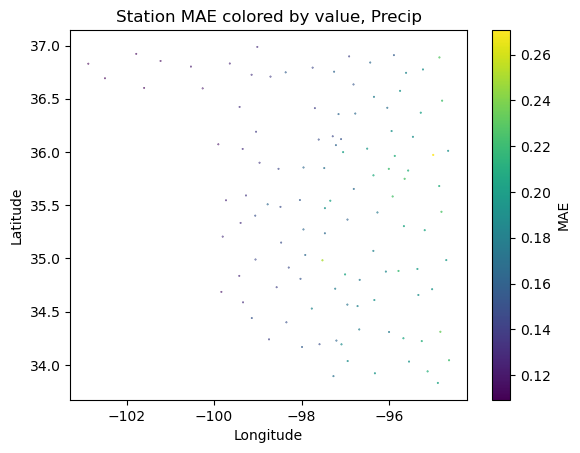

In [413]:
plt.scatter(
    grouped_df["lon"],
    grouped_df["lat"],
    s=grouped_df["mae"],
    c=grouped_df["mae"],
    cmap="viridis",
)
plt.colorbar(label="MAE")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Station MAE colored by value, Precip")
plt.show()

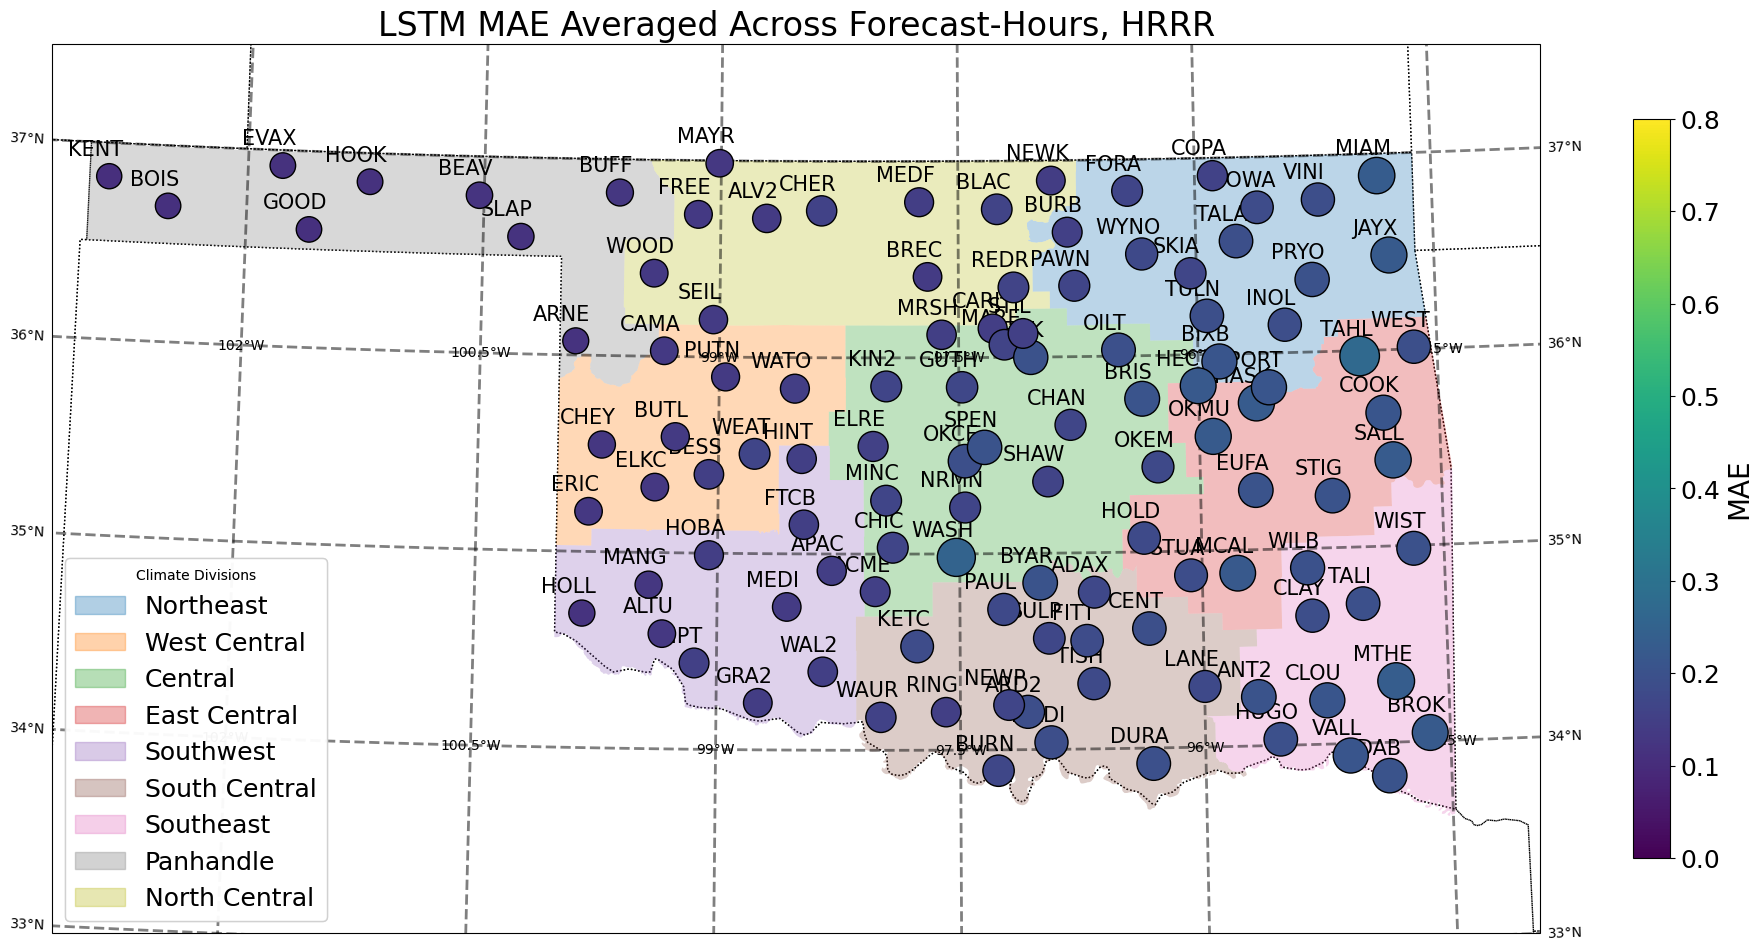

In [414]:
create_xCITE_gif(grouped_df)

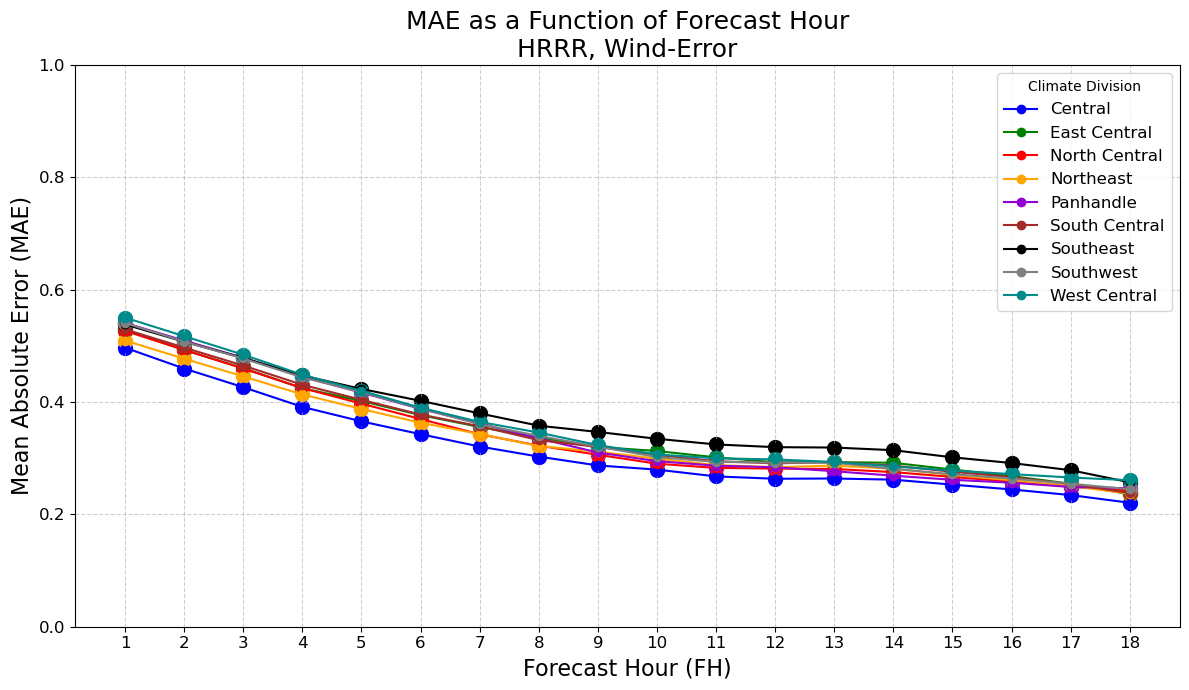

In [415]:
plot_fh_drift(temp_master_ls, error_dir, "HRRR", "Wind")

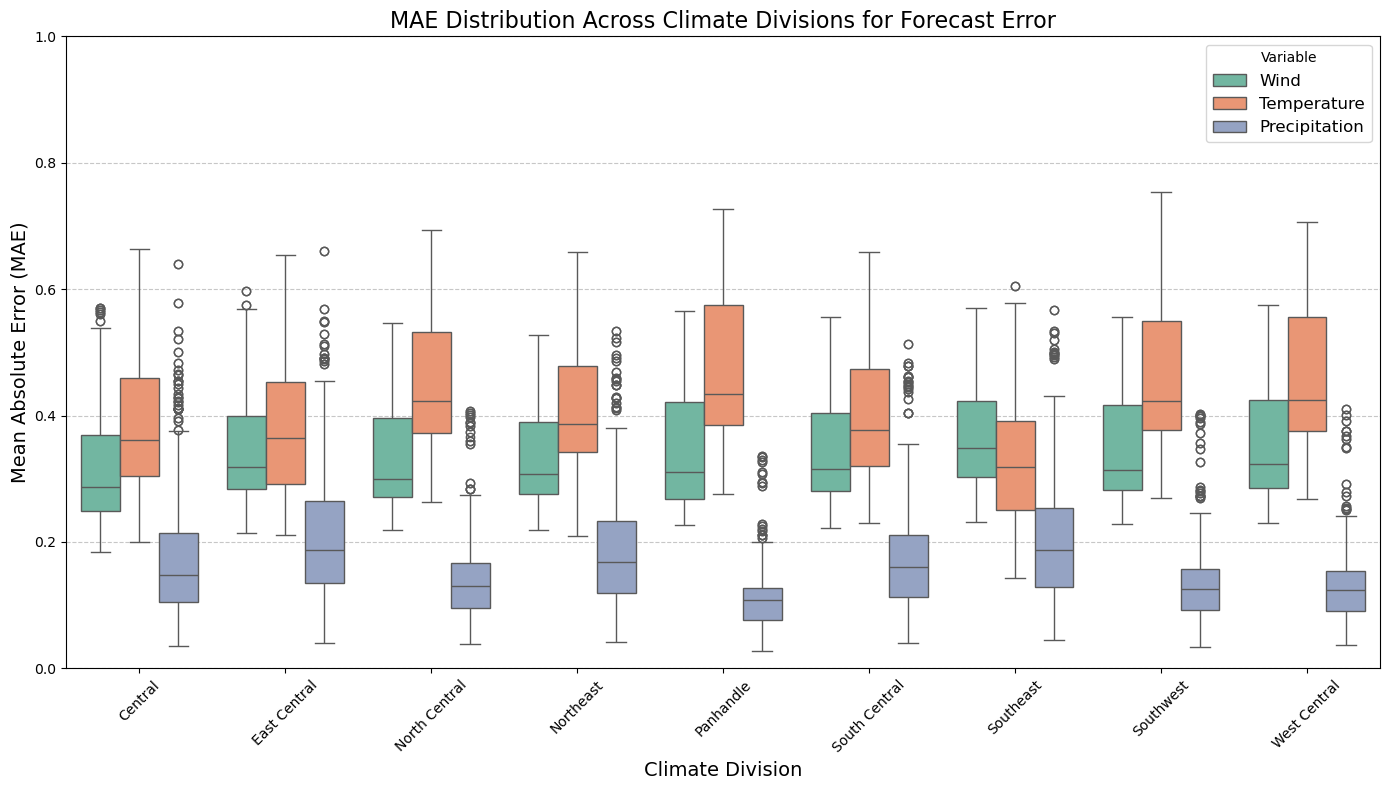

In [416]:
plot_mae_boxplot(temp_df_ls, wind_df_ls, precip_df_ls, error_dir)

In [417]:
def plot_mae_boxplot_geo(wind_df_list, temp_df_list, precip_df_list, geo):
    """
    Creates a grouped boxplot where each climate division has three boxplots
    representing wind error, temperature error, and precipitation error.

    Parameters:
        wind_df_list (list of pd.DataFrame): List of DataFrames containing 'mae' for wind error.
        temp_df_list (list of pd.DataFrame): List of DataFrames containing 'mae' for temperature error.
        precip_df_list (list of pd.DataFrame): List of DataFrames containing 'mae' for precipitation error.
        climate_divisions (list of str): Names of the corresponding climate divisions.
    """
    # Create a list to store the MAE values with their associated climate division and variable type
    plot_data = []

    for clim_div, wind_df, temp_df, precip_df in zip(
        geo, wind_df_list, temp_df_list, precip_df_list
    ):
        if "mae" in wind_df.columns:
            for mae_val in wind_df["mae"]:
                plot_data.append(
                    {"Climate Division": clim_div, "MAE": mae_val, "Variable": "Wind"}
                )

        if "mae" in temp_df.columns:
            for mae_val in temp_df["mae"]:
                plot_data.append(
                    {
                        "Climate Division": clim_div,
                        "MAE": mae_val,
                        "Variable": "Temperature",
                    }
                )

        if "mae" in precip_df.columns:
            for mae_val in precip_df["mae"]:
                plot_data.append(
                    {
                        "Climate Division": clim_div,
                        "MAE": mae_val,
                        "Variable": "Precipitation",
                    }
                )

    # Convert to DataFrame
    plot_df = pd.DataFrame(plot_data)

    # Create the boxplot
    plt.figure(figsize=(14, 8))
    sns.boxplot(
        x="Climate Division", y="MAE", hue="Variable", data=plot_df, palette="Set2"
    )

    # Format the plot
    plt.xlabel("Climate Division", fontsize=14)
    plt.ylabel("Mean Absolute Error (MAE)", fontsize=14)
    plt.title(
        "MAE Distribution Across Climate Divisions for Forecast Error", fontsize=16
    )
    plt.xticks(rotation=45)  # Rotate labels for readability
    plt.legend(title="Variable", fontsize=12, loc="upper left")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [418]:
error_path = "/home/aevans/nwp_bias/src/machine_learning/data/error_visuals"

error_dir = os.listdir(error_path)
error_dir = sorted(error_dir)

temp_master_ls = []
wind_master_ls = []
tp_master_ls = []

temp_df_ls = []
wind_df_ls = []
precip_df_ls = []

for d in error_dir:
    print(d)
    if d not in ["Northern Plateau"]:
        error_df1 = pd.read_parquet(
            f"{error_path}/{d}/{d}_tp_error_metrics_master.parquet"
        ).reset_index()
        error_df2 = pd.read_parquet(
            f"{error_path}/{d}/{d}_u_total_error_metrics_master.parquet"
        ).reset_index()
        error_df3 = pd.read_parquet(
            f"{error_path}/{d}/{d}_t2m_error_metrics_master.parquet"
        ).reset_index()

        error_df1 = geo_map(error_df1, lulc_dict, elev_dict, slope_dict)
        error_df2 = geo_map(error_df2, lulc_dict, elev_dict, slope_dict)
        error_df3 = geo_map(error_df3, lulc_dict, elev_dict, slope_dict)

        # Group by forecast hour (fh) and compute the mean MAE
        mean_mae_by_fh1 = error_df1.groupby("lulc")["mae"].mean().reset_index()
        mean_mae_by_fh2 = error_df2.groupby("lulc")["mae"].mean().reset_index()
        mean_mae_by_fh3 = error_df3.groupby("lulc")["mae"].mean().reset_index()

        temp_df_ls.append(error_df3.reset_index())
        wind_df_ls.append(error_df2.reset_index())
        precip_df_ls.append(error_df1.reset_index())

        mae1 = mean_mae_by_fh1["mae"].values
        mae2 = mean_mae_by_fh2["mae"].values
        mae3 = mean_mae_by_fh3["mae"].values

        temp_master_ls.append(mae3)
        wind_master_ls.append(mae2)
        tp_master_ls.append(mae1)

Central
Central Lakes
Champlain Valley
Coastal
East Central


FileNotFoundError: [Errno 2] No such file or directory: '/home/aevans/nwp_bias/src/machine_learning/data/error_visuals/East Central/East Central_tp_error_metrics_master.parquet'

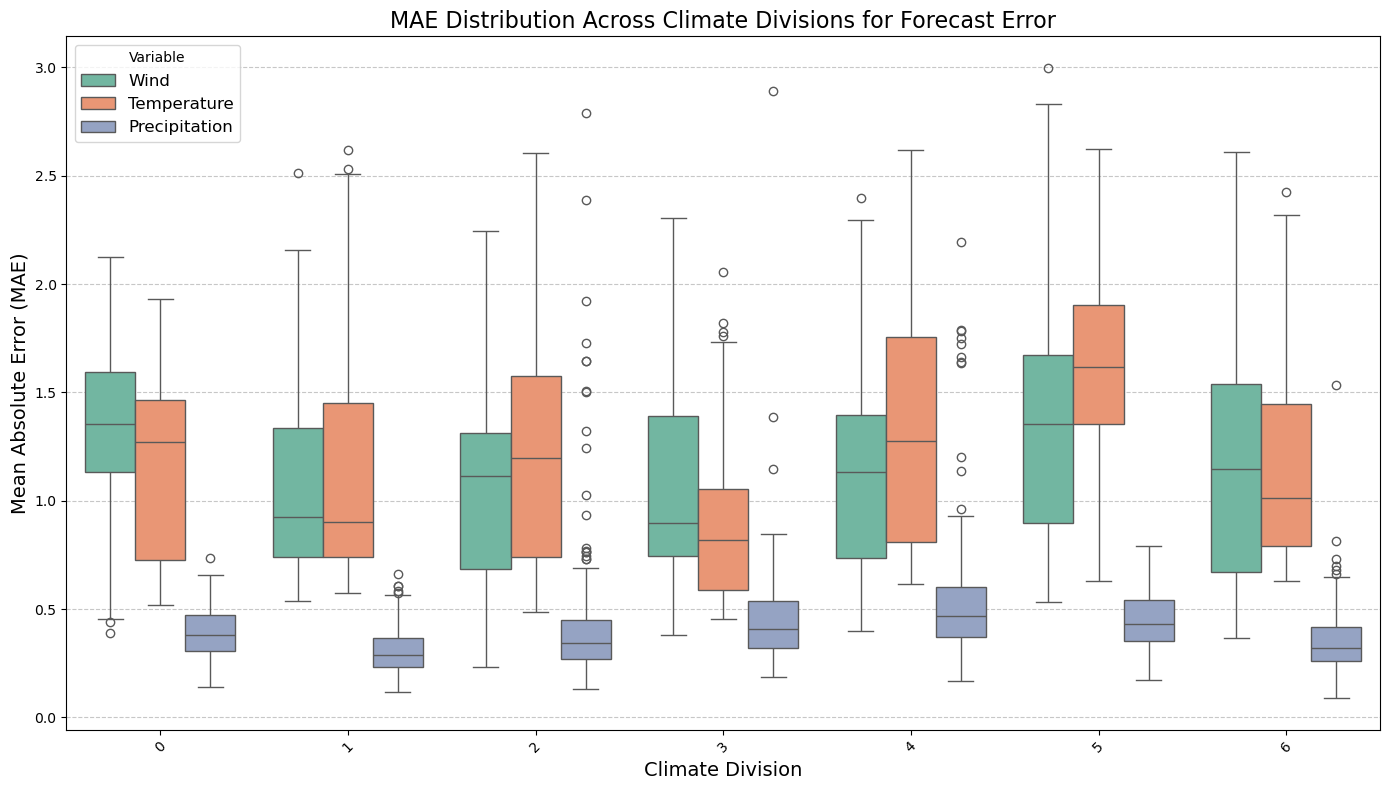

In [ ]:
plot_mae_boxplot_geo(
    wind_df_ls, temp_df_ls, precip_df_ls, geo_info_df["lulc_cat"].unique()
)

In [ ]:
# met_output(nysm_df, "DELE", 6)

In [ ]:
# for k in full_df.columns:
#     if re.search(
#         f"{station}|valid|Model forecast|Abs_err",
#         k,
#     ):
#         continue
#     else:
# full_df = full_df.drop(columns=[k])

In [ ]:
# test_len = int(len(full_df['valid_time'])*0.2)
# full_df = full_df.iloc[0:test_len]

In [ ]:
def groupby_month(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.month), (df.valid_time.dt.year)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(1, len(the_list) + 1)
    plt.bar(x, the_list)
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022, 2023])
    ax.set_xticks(np.arange(1, len(the_list) + 1, int((len(the_list) + 1) / 6)))
    return the_list

/tmp/tmp.vhplsGe5Z8/ipykernel_1159048/2351311710.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022, 2023])


ZeroDivisionError: division by zero

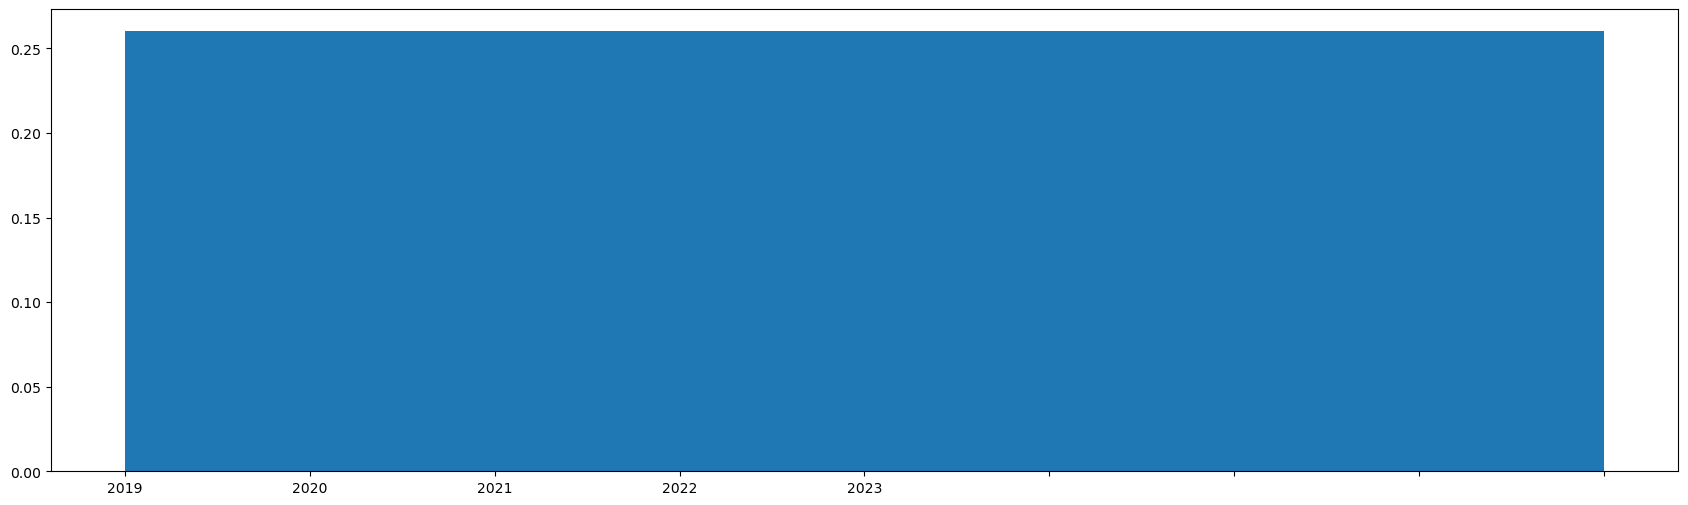

In [ ]:
err_by_month = groupby_month(ldf, "diff")
err_by_month

In [ ]:
def groupby_time(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.hour)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(0, len(the_list))
    plt.bar(x, the_list, color="g")
    return the_list

In [ ]:
err_by_time = groupby_time(ldf, "diff")

In [ ]:
import calendar


def groupby_month_total(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.month)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(0, len(the_list))

    # Get a colormap
    cmap = plt.get_cmap("RdBu")
    # Normalize your data to map to the colormap
    norm = plt.Normalize(min(the_list), max(the_list))
    colors = cmap(norm(the_list))

    # Create a bar chart
    plt.bar(x, the_list, color=colors)
    ax.set_xticks(x)  # Set x-ticks to be at the positions of the months
    month_labels = [calendar.month_name[month] for month in GB.index]
    ax.set_xticklabels(month_labels)  # Label x-ticks with month numbers

    plt.show()
    return the_list

In [ ]:
groupby_month_total(ldf, "diff")

In [ ]:
def myround(x, base):
    return base * round(x / base)

In [ ]:
# function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [ ]:
def err_bucket(full_df, met_col, rounded_base):
    temps = []
    for i, _ in enumerate(full_df[met_col]):
        rounded = myround(full_df[met_col].iloc[i], rounded_base)
        temps.append(rounded)

    unique_temps = unique(temps)

    zeros = np.zeros(len(unique_temps))
    rs = np.resize(zeros, (len(unique_temps), len(unique_temps)))

    temp_df = pd.DataFrame(
        data=rs, index=[np.arange(len(unique_temps))], columns=sorted(unique_temps)
    )

    for i, _ in enumerate(full_df[met_col]):
        rounded = myround(full_df[met_col].iloc[i], rounded_base)
        err = full_df["Abs_err"].iloc[i]
        temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
        temp_df[rounded].iloc[-1] += 1

    instances = temp_df.iloc[-1]
    temp_df = temp_df.iloc[0]

    return temp_df, instances

In [ ]:
def plot_buckets(temp_df, instances, var_name, cmap, width):
    my_cmap = plt.get_cmap(cmap)
    averages = temp_df / instances
    y = averages
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    the_list = averages.tolist()
    fig, ax = plt.subplots(
        figsize=(21, 6), facecolor="slategrey", constrained_layout=True
    )
    bars = plt.bar(temp_df.keys(), the_list, color=my_cmap(rescale(y)), width=width)
    ax.set_title("Absolute Error of LSTM", fontsize=28, c="white")
    ax.set_xlabel(var_name, fontsize=18, c="white")
    ax.set_ylabel("Mean Absolute Error", fontsize=18, c="white")
    # Iterating over the bars one-by-one
    # Annotate each bar with its value
    # Annotate each bar with the number of instances
    for bar, value, instance_count in zip(bars, the_list, instances):
        yval = value + 0.01  # Adjust the vertical position of the label
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"n={instance_count}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=12,
            rotation=90,
        )

In [ ]:
# for k in full_df.keys():
#     print(k)

In [ ]:
# diector = sorted(os.listdir('/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231129/'))

# for d in diector:
#         full_df = pd.read_parquet(
#         f"/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231129/{d}"
#     )
#         for k in full_df.columns:
#             if re.search(
#                 f"{station}",
#                 k,
#             ):
#                 print("Succes!!")
#                 print(d)
#             else:
#                 continue

In [ ]:
ldf

In [ ]:
# Reset index for both DataFrames to ensure alignment
full_df = nysm_df.copy()
full_df = full_df[full_df["station"] == "DELE"]
full_df = full_df.merge(ldf, on="valid_time")
full_df = full_df.rename(columns={"diff": "Abs_err"})
full_df = full_df[full_df["Abs_err"].abs() > 1.5]

In [ ]:
full_df.dropna(inplace=True)

In [ ]:
full_df["Abs_err"].unique()

In [ ]:
temp_df, instances = err_bucket(full_df, f"tair", 2)

In [ ]:
instances

In [ ]:
plot_buckets(temp_df, instances, "Temperature (C)", "Wistia", 2.5)

In [ ]:
relh_df, instances = err_bucket(full_df, f"relh", 2)

In [ ]:
plot_buckets(relh_df, instances, "Relative Humidity (%)", "copper", 5.0)

In [ ]:
new_df, instances = err_bucket(full_df, f"srad", 40)

In [ ]:
plot_buckets(new_df, instances, "Solar Radiation (W / m*m)", "copper", 50.0)

In [ ]:
pres_df, instances = err_bucket(full_df, f"pres", 2)

In [ ]:
print(f'The mean pressure at {station} is {full_df[f"pres"].mean()}')

In [ ]:
plot_buckets(pres_df, instances, "Surface Pressure (mb)", "copper", 1.5)

In [ ]:
def round_small(full_df, met_col, rounded_base):
    temps = []
    for i, _ in enumerate(full_df[met_col]):
        if full_df[met_col].iloc[i] < 1.0 and full_df[met_col].iloc[i] >= 0:
            rounded = round(full_df[met_col].iloc[i], rounded_base)
            temps.append(rounded)
        else:
            rounded = myround(full_df[met_col].iloc[i], 1)
            temps.append(rounded)

    unique_temps = unique(temps)

    zeros = np.zeros(len(unique_temps))
    rs = np.resize(zeros, (len(unique_temps), len(unique_temps)))
    temp_df = pd.DataFrame(
        data=rs, index=[np.arange(len(unique_temps))], columns=sorted(unique_temps)
    )

    for i, _ in enumerate(full_df[met_col]):
        if full_df[met_col].iloc[i] < 1.0 and full_df[met_col].iloc[i] >= 0:
            rounded = round(full_df[met_col].iloc[i], rounded_base)
        else:
            rounded = float(myround(full_df[met_col].iloc[i], base=1))
        err = float(full_df["Abs_err"].iloc[i])
        temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
        temp_df[rounded].iloc[-1] += 1

    instances = temp_df.iloc[-1]
    temp_df = temp_df.iloc[0]
    temp_df = temp_df.loc[~(temp_df == 0)]
    instances = instances.loc[~(instances == 0)]
    return temp_df, instances

In [ ]:
rain_df, instances = err_bucket(full_df, f"precip_total", 0.1)

In [ ]:
plot_buckets(rain_df, instances, "Precipitation [mm/hr]", "winter", 1.0)

In [ ]:
snow_df, instances = round_small(full_df, f"snow_depth", 2)

In [ ]:
snow_df = snow_df.iloc[1:]
instances = instances.iloc[1:]

In [ ]:
plot_buckets(snow_df, instances, "Accumulated Snow (m)", "cool", 0.01)

In [ ]:
wmax, instances = err_bucket(full_df, f"wmax_sonic", 2)

In [ ]:
plot_buckets(wmax, instances, "Wind Max (m/s)", "copper", 1.0)

In [ ]:
wdir, instances = err_bucket(full_df, f"wdir_sonic", 45)

In [ ]:
plot_buckets(wdir, instances, "Wind Dir (degrees)", "copper", 10.0)